In [45]:
import pandas as pd
import matplotlib.pyplot as plt

In [46]:

# Load the dataset
file_path = '../The_Seal_dataset/CP_count_Seal.csv'  # Update this with the actual file path
data = pd.read_csv(file_path)

# List of assay columns to process (assuming all columns except INCHIKEY and the last 13 columns are assays)
assay_columns = data.columns[6:-13]

# Initialize a list to store results
results = []
assay_columns

Index(['CHEMBL1613870', 'CHEMBL1741321', 'CHEMBL1741322', 'CHEMBL1741323',
       'CHEMBL1741324', 'CHEMBL1741325', 'CHEMBL1909087', 'CHEMBL1909088',
       'CHEMBL1909089', 'CHEMBL1909090', 'CHEMBL1909091', 'CHEMBL1909092',
       'CHEMBL1909104', 'CHEMBL1909105', 'CHEMBL1909108', 'CHEMBL1909109',
       'CHEMBL1909110', 'CHEMBL1909130', 'CHEMBL1909140', 'CHEMBL1909141',
       'CHEMBL1909150', 'CHEMBL1909156', 'CHEMBL1909170', 'CHEMBL1909172',
       'CHEMBL1909173', 'CHEMBL1909174', 'CHEMBL1909211', 'CHEMBL5291729',
       'CHEMBL5291731', 'CHEMBL5291732', 'CHEMBL5291736', 'CHEMBL5291737',
       'CHEMBL5291738', 'CHEMBL5291742', 'CHEMBL5291749', 'CHEMBL5291761',
       'CHEMBL5291763', 'CHEMBL5291766', 'CHEMBL5291767', 'CHEMBL5291779',
       'CHEMBL5291781', 'CHEMBL5291782', 'CHEMBL5291809', 'CHEMBL5291811',
       'CHEMBL5291815', 'CHEMBL5291818', 'CHEMBL5291822', 'CHEMBL5291823',
       'CHEMBL5291828', 'CHEMBL5291850', 'CHEMBL5291863', 'CHEMBL5291882',
       'CHEMBL5291891', '

In [70]:
len(assay_columns)

57

In [68]:
data["CHEMBL1741321"].value_counts()

0.0    614
1.0    232
Name: CHEMBL1741321, dtype: int64

In [72]:
data[["Standardized_InChIKey_chembl", "CHEMBL1741321"]].to_csv("../Compare_Hofmarcher_Data/Seal_CHEMBL1741321.csv")

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, roc_auc_score
from tqdm import tqdm

# Load the dataset
file_path = '../The_Seal_dataset/CP_count_Seal.csv'  # Update this with the actual file path
data = pd.read_csv(file_path)

# List of assay columns to process (assuming all columns except INCHIKEY and the last 13 columns are assays)
assay_columns = data.columns[6:-13]

# Initialize a list to store results
results = []

# Define a function to calculate a probability score based on the distance from the threshold
def calculate_probability_score(value, threshold):
    return 1 / (1 + np.exp(value - threshold))

# Define threshold range based on the dataset
min_value = data['Cells_Number_Object_Number'].min()
max_value = data['Cells_Number_Object_Number'].max()
thresholds = np.arange(min_value, max_value, 1)

# Process each assay and each threshold
for assay in tqdm(assay_columns):
    # Drop rows with NaNs or -1s in the current assay column or in Cells_Number_Object_Number
    valid_data = data[(data[assay] != -1) & (data[assay].notna())].copy().reset_index(drop=True)

    # Process for each threshold
    for threshold in thresholds:
    
        # Calculate the probability score
        valid_data.loc[:, 'Probability_Score'] = valid_data['Cells_Number_Object_Number'].apply(calculate_probability_score, threshold=threshold)
        # print(valid_data[['Probability_Score']])
        # True values for the assay
        true_values = valid_data[assay] == 1
        predicted_probs = valid_data['Probability_Score']
        predicted_values = valid_data['Probability_Score'] >= 0.5

        # Calculate TP, FP, TN, FN
        TP = np.sum((predicted_values == 1) & (true_values == 1))
        FP = np.sum((predicted_values == 1) & (true_values == 0))
        TN = np.sum((predicted_values == 0) & (true_values == 0))
        FN = np.sum((predicted_values == 0) & (true_values == 1))

        # Calculate metrics
        accuracy = accuracy_score(true_values, predicted_values)
        balanced_accuracy = balanced_accuracy_score(true_values, predicted_values)
        recall = recall_score(true_values, predicted_values, zero_division=0)
        precision = precision_score(true_values, predicted_values, zero_division=0)
        auc = roc_auc_score(true_values, predicted_probs)
        # print(auc)

        # Append the result
        results.append({
            'Assay': assay,
            'Accuracy': accuracy,
            'Balanced Accuracy': balanced_accuracy,
            'Recall': recall,
            'Precision': precision,
            'Threshold': threshold,
            'AUC': auc,
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('assay_auc_by_threshold_with_confusion_Seal.csv', index=False)


100%|██████████| 57/57 [00:19<00:00,  2.96it/s]


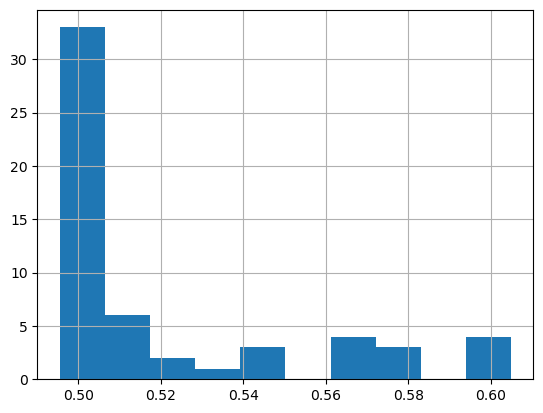

In [74]:
results_df = pd.read_csv('assay_auc_by_threshold_with_confusion_Seal.csv')

results_df[results_df["Assay"]=="CHEMBL1741321"]["Balanced Accuracy"].hist()
plt.show()

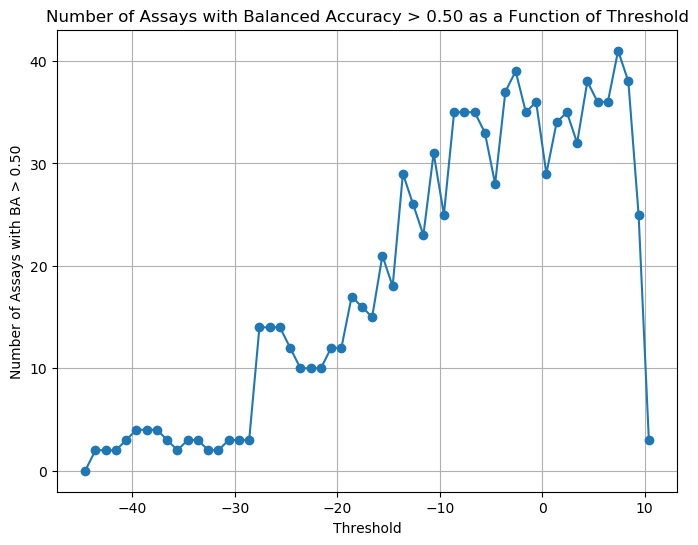

In [49]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['Balanced Accuracy'] > 0.50).sum()).reset_index(name='Assays with BA > 0.50')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with BA > 0.50'], marker='o', linestyle='-')
plt.title('Number of Assays with Balanced Accuracy > 0.50 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with BA > 0.50')
plt.grid(True)
plt.show()

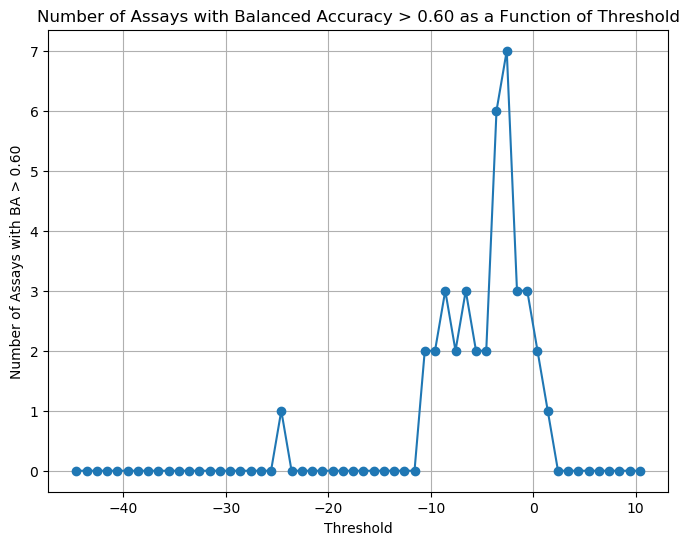

In [50]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['Balanced Accuracy'] > 0.60).sum()).reset_index(name='Assays with BA > 0.50')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with BA > 0.50'], marker='o', linestyle='-')
plt.title('Number of Assays with Balanced Accuracy > 0.60 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with BA > 0.60')
plt.grid(True)
plt.show()


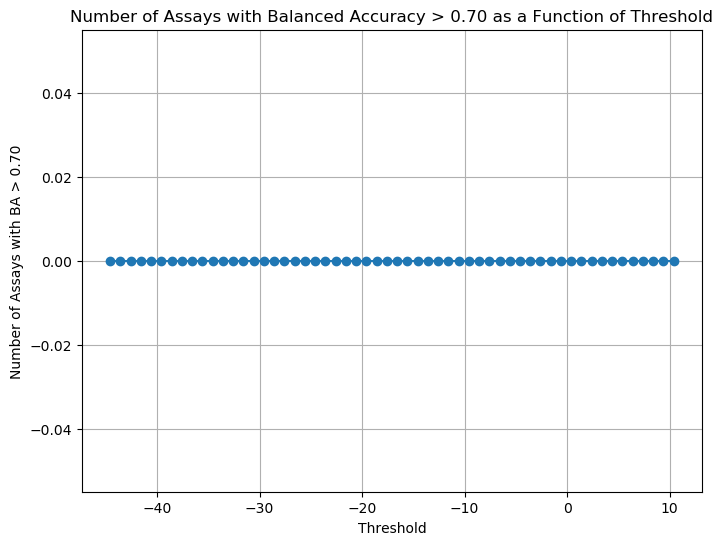

In [51]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['Balanced Accuracy'] > 0.70).sum()).reset_index(name='Assays with BA > 0.70')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with BA > 0.70'], marker='o', linestyle='-')
plt.title('Number of Assays with Balanced Accuracy > 0.70 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with BA > 0.70')
plt.grid(True)
plt.show()


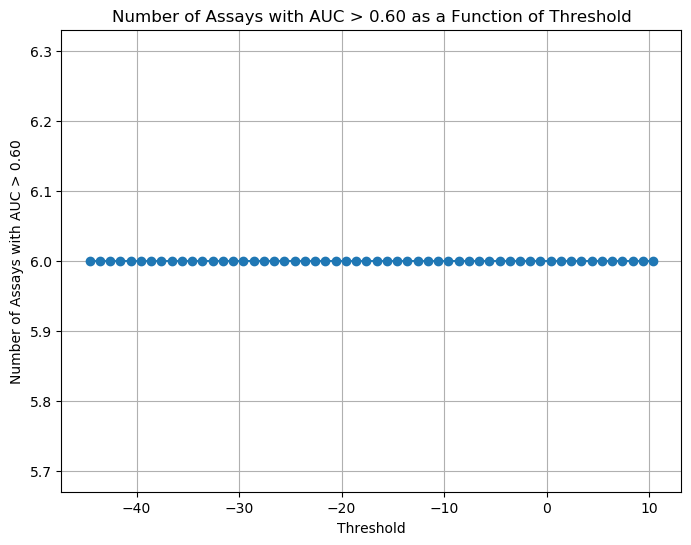

In [52]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['AUC'] > 0.60).sum()).reset_index(name='Assays with AUC>')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with AUC>'], marker='o', linestyle='-')
plt.title('Number of Assays with AUC > 0.60 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with AUC > 0.60')
plt.grid(True)
plt.show()


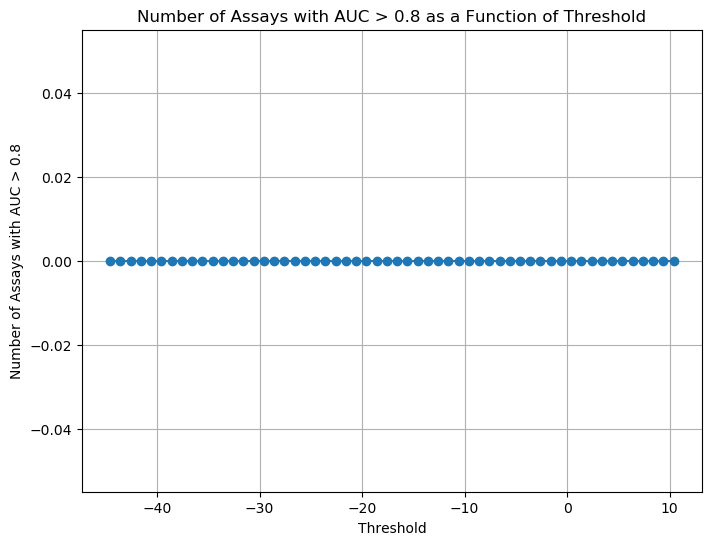

In [53]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['AUC'] > 0.8).sum()).reset_index(name='Assays with AUC>')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with AUC>'], marker='o', linestyle='-')
plt.title('Number of Assays with AUC > 0.8 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with AUC > 0.8')
plt.grid(True)
plt.show()


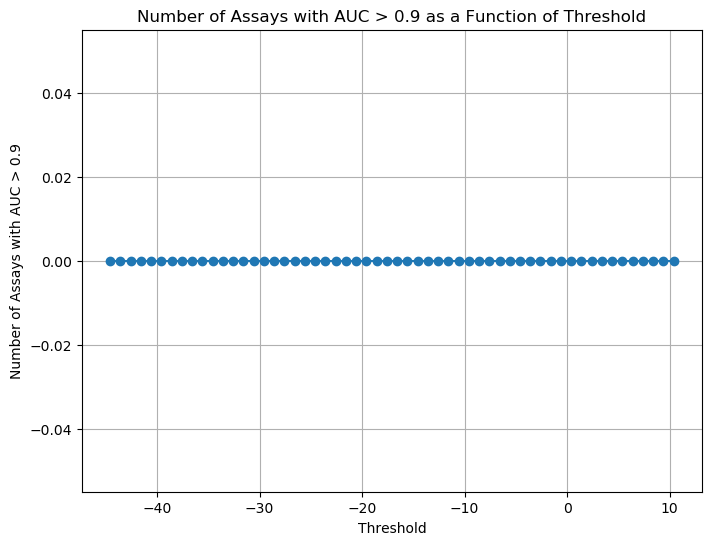

In [54]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['AUC'] > 0.9).sum()).reset_index(name='Assays with AUC>')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with AUC>'], marker='o', linestyle='-')
plt.title('Number of Assays with AUC > 0.9 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with AUC > 0.9')
plt.grid(True)
plt.show()


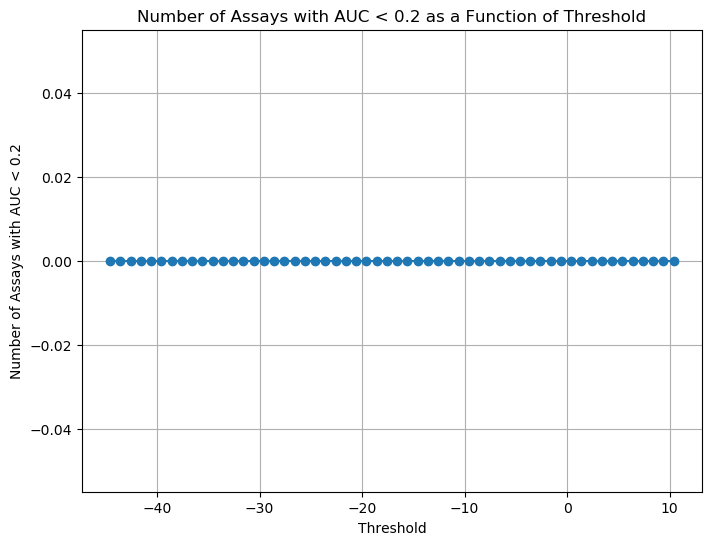

In [55]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['AUC'] < 0.2).sum()).reset_index(name='Assays with AUC<')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with AUC<'], marker='o', linestyle='-')
plt.title('Number of Assays with AUC < 0.2 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with AUC < 0.2')
plt.grid(True)
plt.show()

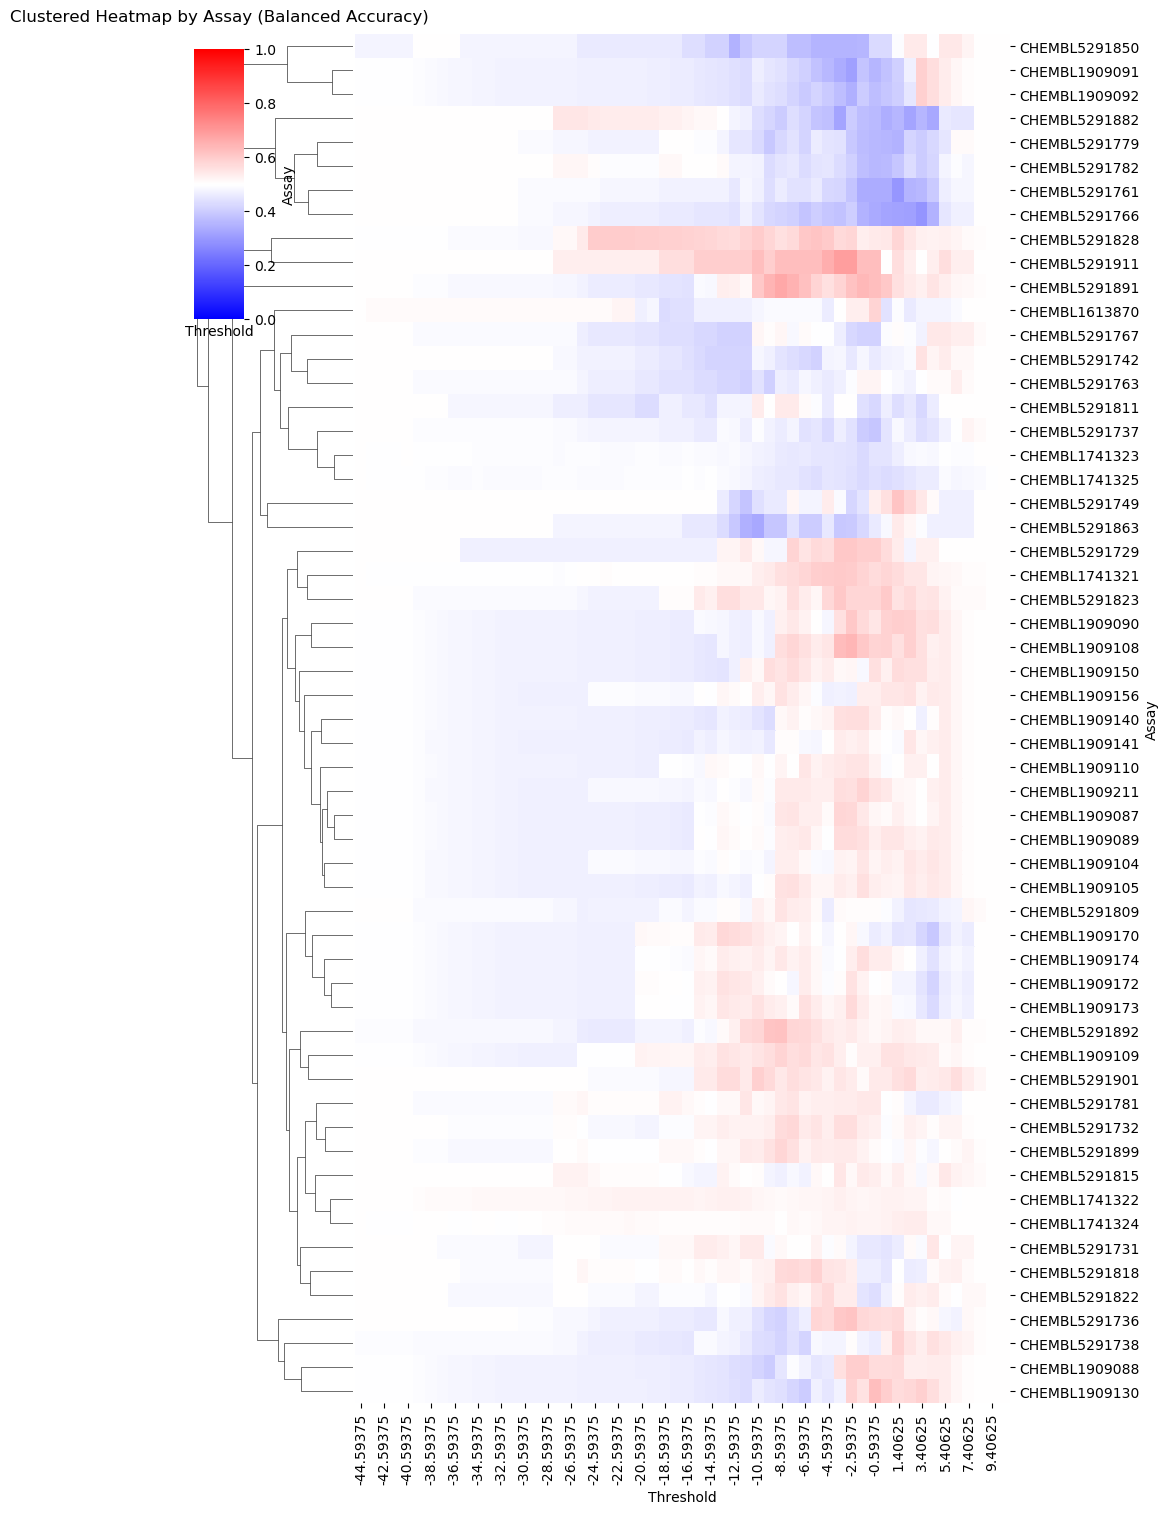

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])

# Create a pivot table for the heatmap, with 'Assay' as rows, 'Threshold' as columns, and 'Balanced Accuracy' as values
heatmap_data = results_df.pivot(index='Assay', columns='Threshold', values='Balanced Accuracy')

# Plot the clustered heatmap with clustering only by Assay (rows)
sns.clustermap(heatmap_data, cmap=custom_cmap, cbar=True, figsize=(10, 15), 
               row_cluster=True, col_cluster=False, dendrogram_ratio=(0.2, 0), method='average',
               center=0.5, vmin=0, vmax=1)

plt.title('Clustered Heatmap by Assay (Balanced Accuracy)', pad=20)
plt.xlabel('Threshold')
plt.ylabel('Assay')
plt.show()


In [56]:
results_df["Balanced Accuracy_success"] = results_df["Balanced Accuracy"].apply(lambda x: 1 - x if x < 0.5 else x)
results_df["AUC_success"] = results_df["AUC"].apply(lambda x: 1 - x if x < 0.5 else x)


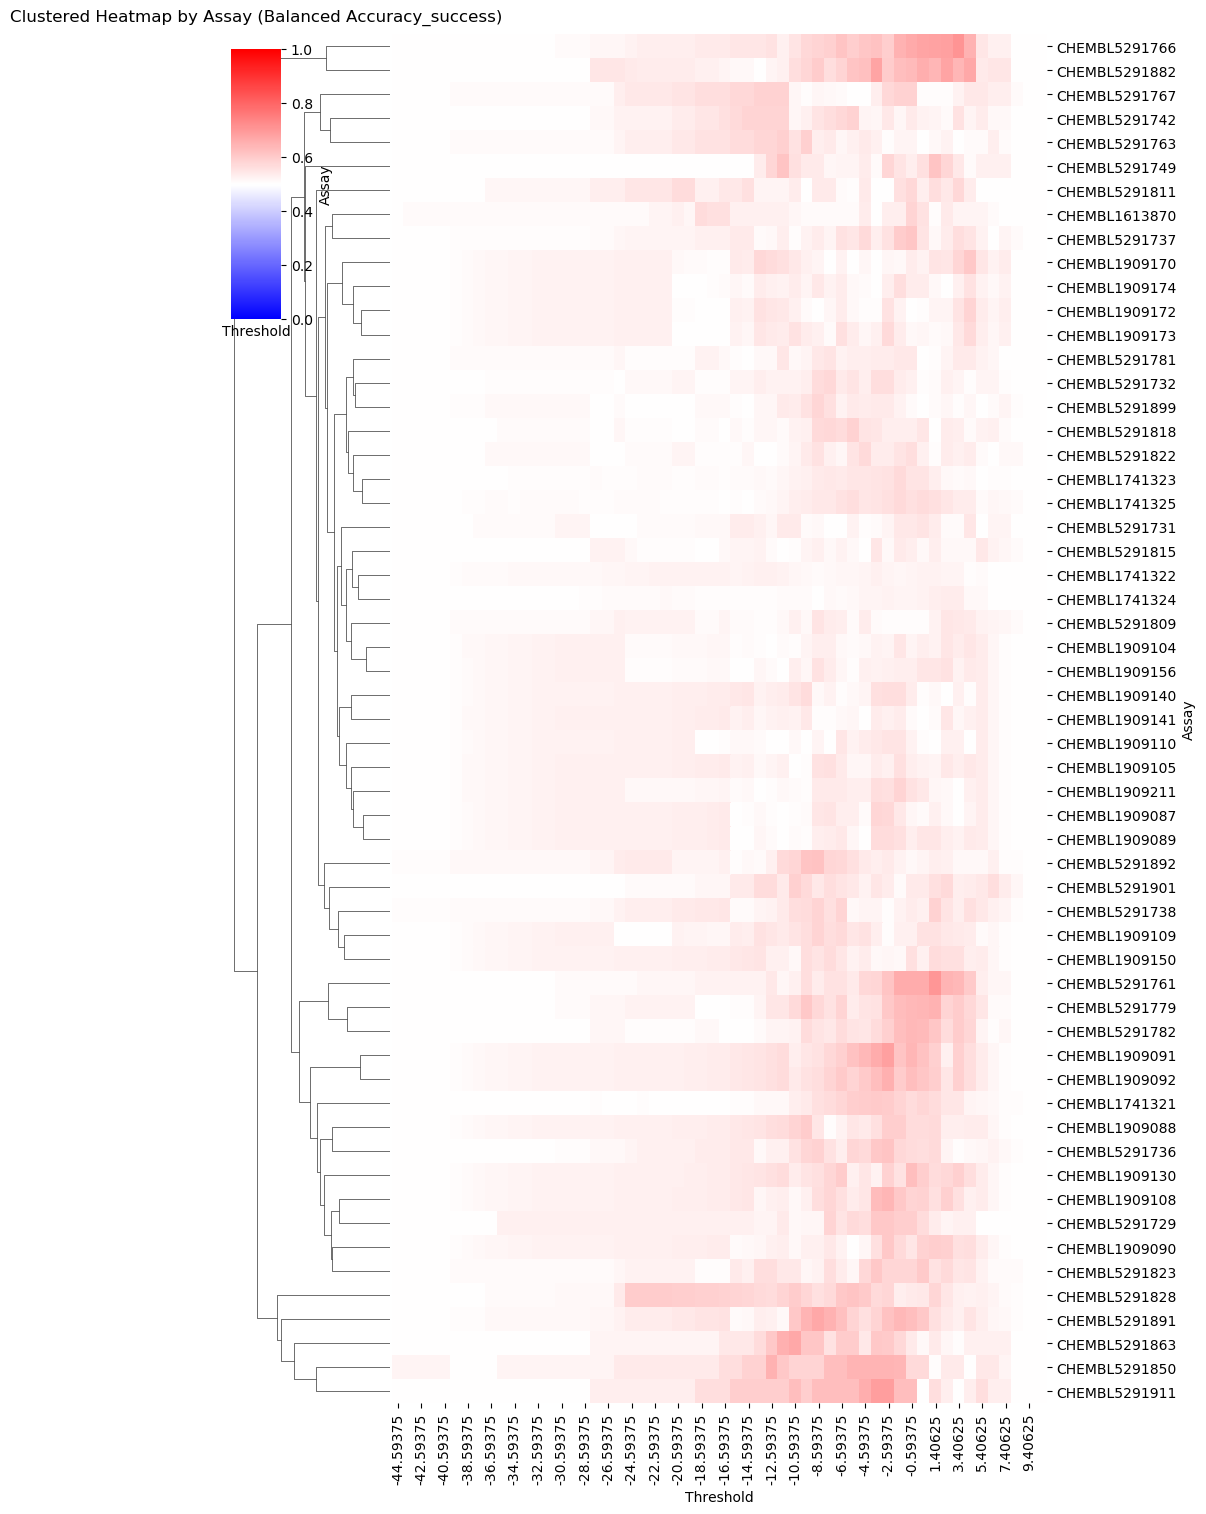

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])

# Create a pivot table for the heatmap, with 'Assay' as rows, 'Threshold' as columns, and 'Balanced Accuracy' as values
heatmap_data = results_df.pivot(index='Assay', columns='Threshold', values='Balanced Accuracy_success')

# Plot the clustered heatmap with clustering only by Assay (rows)
sns.clustermap(heatmap_data, cmap=custom_cmap, cbar=True, figsize=(10, 15), 
               row_cluster=True, col_cluster=False, dendrogram_ratio=(0.2, 0), method='average',
               center=0.5, vmin=0, vmax=1)

plt.title('Clustered Heatmap by Assay (Balanced Accuracy_success)', pad=20)
plt.xlabel('Threshold')
plt.ylabel('Assay')
plt.show()


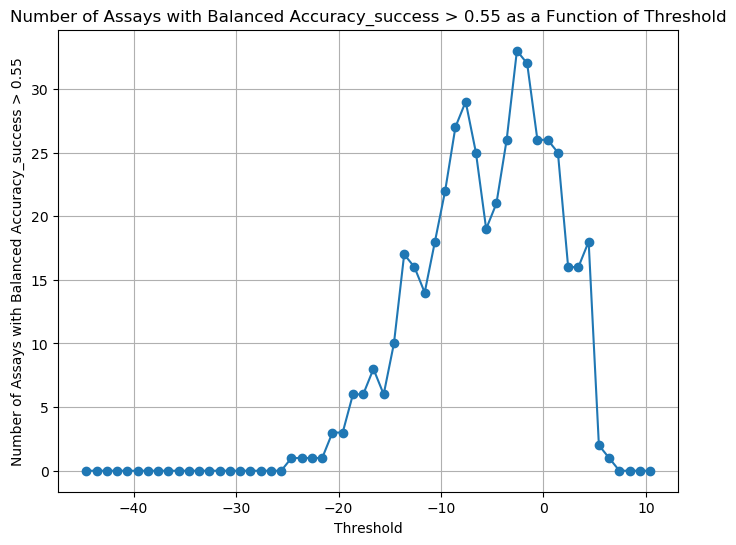

In [62]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['Balanced Accuracy_success'] > 0.55).sum()).reset_index(name='Assays with Balanced Accuracy_success > 0.55')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with Balanced Accuracy_success > 0.55'], marker='o', linestyle='-')
plt.title('Number of Assays with Balanced Accuracy_success > 0.55 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with Balanced Accuracy_success > 0.55')
plt.grid(True)
plt.show()


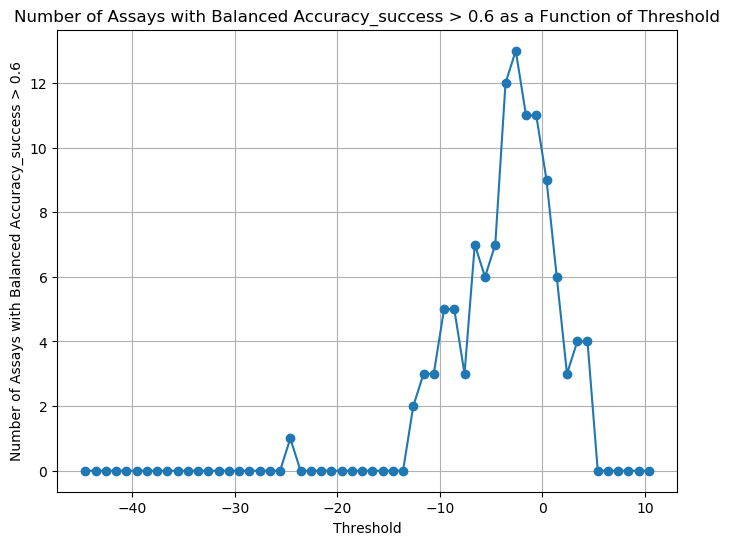

In [63]:
# Group by threshold and count how many assays have balanced accuracy > 0.50 at each threshold
threshold_counts = results_df.groupby('Threshold').apply(lambda x: (x['Balanced Accuracy_success'] > 0.6).sum()).reset_index(name='Assays with Balanced Accuracy_success > 0.6')

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(threshold_counts['Threshold'], threshold_counts['Assays with Balanced Accuracy_success > 0.6'], marker='o', linestyle='-')
plt.title('Number of Assays with Balanced Accuracy_success > 0.6 as a Function of Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Assays with Balanced Accuracy_success > 0.6')
plt.grid(True)
plt.show()


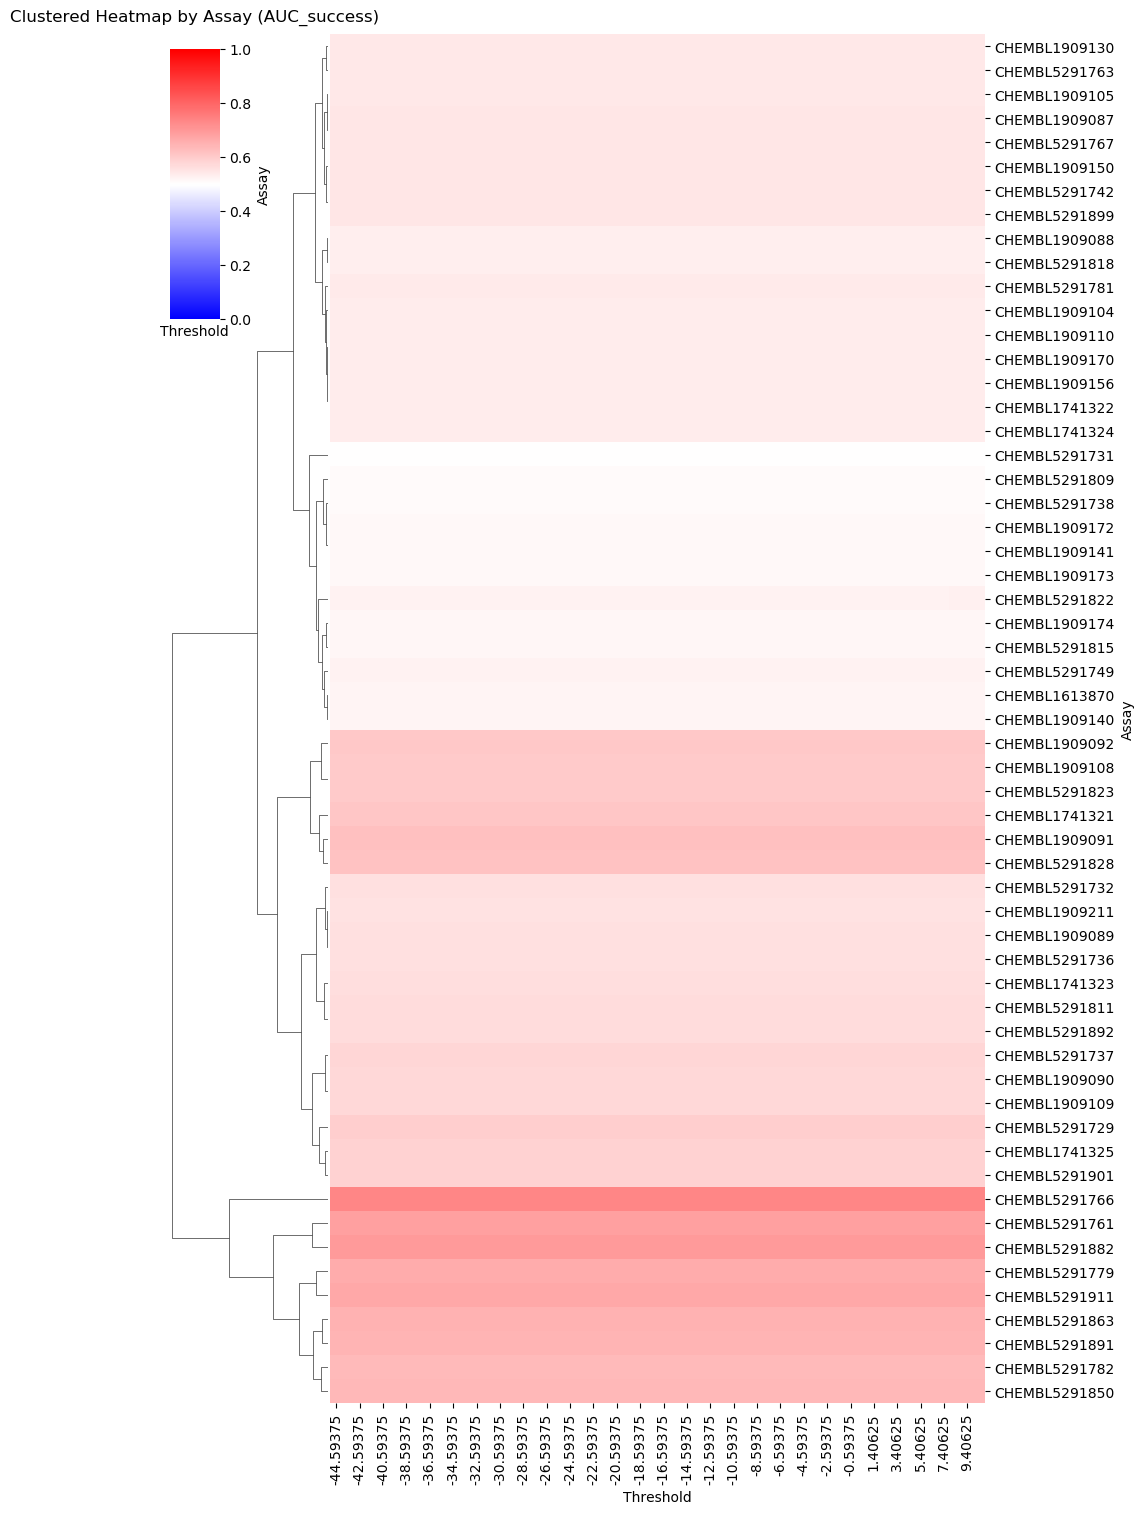

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])

# Create a pivot table for the heatmap, with 'Assay' as rows, 'Threshold' as columns, and 'Balanced Accuracy' as values
heatmap_data = results_df.pivot(index='Assay', columns='Threshold', values='AUC_success')

# Plot the clustered heatmap with clustering only by Assay (rows)
sns.clustermap(heatmap_data, cmap=custom_cmap, cbar=True, figsize=(10, 15), 
               row_cluster=True, col_cluster=False, dendrogram_ratio=(0.2, 0), method='average',
               center=0.5, vmin=0, vmax=1)

plt.title('Clustered Heatmap by Assay (AUC_success)', pad=20)
plt.xlabel('Threshold')
plt.ylabel('Assay')
plt.show()
